<a href="https://colab.research.google.com/github/piaseckazaneta/CV/blob/master/Project1_RiceLeafDiseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import os
import shutil
import random

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image_dataset_from_directory

1. Loading data

In [2]:
base_dir = '/content/drive/MyDrive/Project1_RiceLeafDiseases/rice_leaf_diseases'
print(os.listdir(base_dir))  # Wyświetla foldery chorób


['Bacterial leaf blight', 'Leaf smut', 'Brown spot']


3. Wczytanie danych przy użyciu image_dataset_from_directory
TensorFlow dostarcza funkcji image_dataset_from_directory, która automatycznie wczytuje dane z folderów.

a) Wczytanie zbiorów treningowego,walidacyjnego i testowego:

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

b) Utwórz nowe foldery dla podziału danych.

Najpierw utwórz foldery dla zbiorów treningowego, walidacyjnego i testowego:

In [5]:
base_dir = '/content/drive/MyDrive/Project1_RiceLeafDiseases/rice_leaf_diseases'  # Ścieżka do folderu z danymi

# Ścieżka do folderów docelowych
output_dir = '/content/drive/MyDrive/Project1_RiceLeafDiseases/split_data'
os.makedirs(output_dir, exist_ok=True)

for split in ['train', 'val', 'test']:
    for category in os.listdir(base_dir):
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)


c) Podziel dane na zbiory


W tym kroku wybierzesz proporcje podziału (np. 70% danych na trening, 20% na walidację, 10% na test).

In [ ]:
# Proporcje podziału
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Podział danych
for category in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category)
    images = os.listdir(category_path)
    random.shuffle(images)  # Wymieszaj dane losowo

    # Oblicz liczbę próbek dla każdego zbioru
    train_count = int(len(images) * train_ratio)
    val_count = int(len(images) * val_ratio)

    # Podziel dane
    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    # Przenieś pliki do odpowiednich folderów
    for image in train_images:
        shutil.copy(os.path.join(category_path, image),
                    os.path.join(output_dir, 'train', category, image))

    for image in val_images:
        shutil.copy(os.path.join(category_path, image),
                    os.path.join(output_dir, 'val', category, image))

    for image in test_images:
        shutil.copy(os.path.join(category_path, image),
                    os.path.join(output_dir, 'test', category, image))

print("Dane zostały podzielone!")

2. Zweryfikuj podział

Po wykonaniu podziału możesz sprawdzić, czy dane zostały poprawnie przeniesione:

In [6]:
# Liczba obrazów w każdym zbiorze
for split in ['train', 'val', 'test']:
    for category in os.listdir(base_dir):
        split_dir = os.path.join(output_dir, split, category)
        print(f"{split}/{category}: {len(os.listdir(split_dir))} obrazów")


train/Bacterial leaf blight: 28 obrazów
train/Leaf smut: 28 obrazów
train/Brown spot: 28 obrazów
val/Bacterial leaf blight: 8 obrazów
val/Leaf smut: 8 obrazów
val/Brown spot: 8 obrazów
test/Bacterial leaf blight: 4 obrazów
test/Leaf smut: 4 obrazów
test/Brown spot: 4 obrazów


3. Wczytaj dane do TensorFlow

Teraz możesz wczytać dane podzielone na zbiory przy użyciu image_dataset_from_directory:

In [8]:
from tensorflow.keras.utils import image_dataset_from_directory

data_dir = '/content/drive/MyDrive/Project1_RiceLeafDiseases/split_data'

# Wczytaj dane treningowe, walidacyjne i testowe
train_ds = image_dataset_from_directory(
    os.path.join(data_dir, 'train'),
    image_size=(224, 224),
    batch_size=32
)

val_ds = image_dataset_from_directory(
    os.path.join(data_dir, 'val'),
    image_size=(224, 224),
    batch_size=32
)

test_ds = image_dataset_from_directory(
    os.path.join(data_dir, 'test'),
    image_size=(224, 224),
    batch_size=32
)


Found 84 files belonging to 3 classes.
Found 24 files belonging to 3 classes.
Found 12 files belonging to 3 classes.


Weryfikacja zbioru testowego

Po wczytaniu zbioru testowego możesz sprawdzić, czy dane zostały poprawnie załadowane:

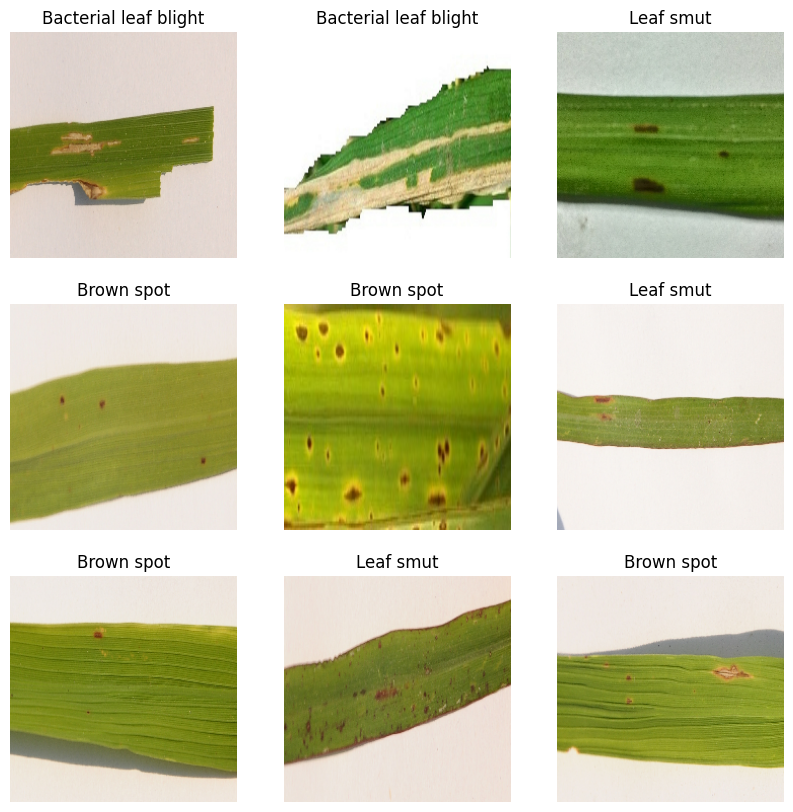

In [9]:
import matplotlib.pyplot as plt

# Wyświetlenie kilku obrazów z testowego
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):  # Pobranie pierwszego batcha
    for i in range(9):  # Wyświetlenie 9 obrazów
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")


4. Zdefiniowanie bazy modelu Transfer Learning

Użyj pretrenowanego modelu, np. ResNet50:

In [11]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Wyjaśnienie:
weights="imagenet" – załadowanie wag wytrenowanych na zbiorze ImageNet.

include_top=False – usuwa wierzchołek sieci (warstwy odpowiedzialne za klasyfikację), aby można było dodać własne.

input_shape=(224, 224, 3) – oczekiwany kształt obrazu (224x224, 3 kanały RGB).

5. Zamrożenie warstw bazy

Zamroź bazowe warstwy modelu (nie będą trenowane), aby zachować wytrenowane cechy:

In [12]:
base_model.trainable = False


6. Dodanie własnych warstw klasyfikacyjnych

Dodaj wierzchołek do sieci, dostosowany do liczby klas:

In [13]:
num_classes = len(train_ds.class_names)

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Warstwa uśredniająca cechy
    layers.Dense(128, activation='relu'),  # Dodatkowa warstwa gęsta
    layers.Dropout(0.5),  # Regularizacja
    layers.Dense(num_classes, activation='softmax')  # Wyjściowa warstwa klasyfikacji
])


7. Kompilacja modelu

Skompiluj model z odpowiednimi hiperparametrami:

In [18]:
from tensorflow.keras.metrics import Precision, Recall


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  # Dla etykiet numerycznych (0, 1, 2, ...)
    metrics=['accuracy', 'precision', 'recall']
)


8. Trenowanie modelu

Uruchom proces trenowania:

In [19]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node LogicalAnd defined at (most recent call last):
<stack traces unavailable>
Incompatible shapes: [1,32] vs. [1,96]
	 [[{{node LogicalAnd}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_24238[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_24929]

9. Ewaluacja modelu

Po zakończeniu trenowania przetestuj model na zbiorze testowym:

In [16]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7500 - loss: 0.7966
Test accuracy: 0.75


9. Wizualizacja wyników

Zobacz, jak model radził sobie podczas trenowania:

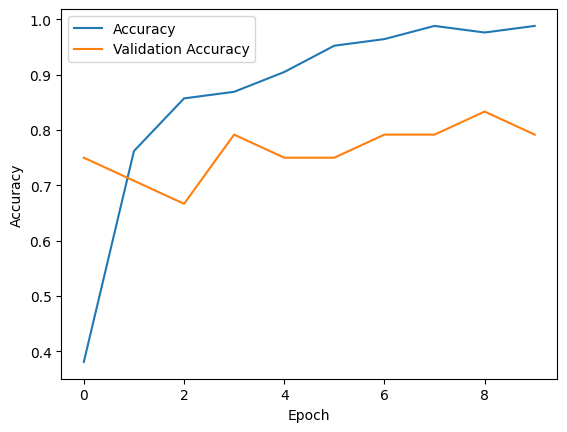

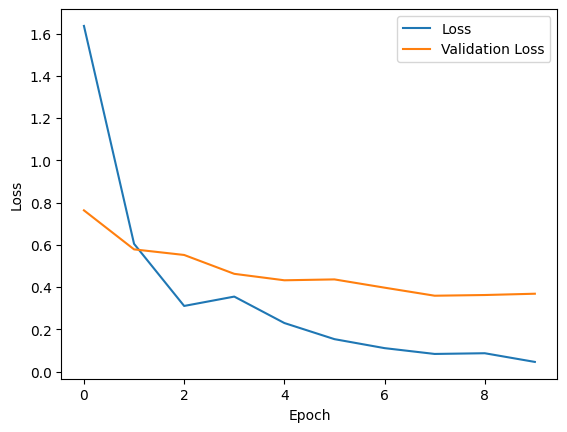

In [17]:
import matplotlib.pyplot as plt

# Wykresy dokładności
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Wykresy straty
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


METRYKI

Predykcja na zbiorze testowym:

In [20]:
import numpy as np

# Pobierz przewidywania modelu
y_pred = np.argmax(model.predict(test_ds), axis=1)

# Pobierz prawdziwe etykiety z test_ds
y_true = np.concatenate([y for x, y in test_ds], axis=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


np.argmax(model.predict(test_ds), axis=1) – zamienia wyjścia modelu na etykiety klas (najwyższe prawdopodobieństwo).

y_true – łączy prawdziwe etykiety z wszystkich batchy.

Obliczenie metryk: Użyj funkcji z sklearn.metrics:

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

# Wygeneruj raport klasyfikacji
print(classification_report(y_true, y_pred, target_names=test_ds.class_names))

# Opcjonalnie: Macierz konfuzji
print(confusion_matrix(y_true, y_pred))


                       precision    recall  f1-score   support

Bacterial leaf blight       0.50      0.50      0.50         4
           Brown spot       0.75      0.75      0.75         4
            Leaf smut       0.50      0.50      0.50         4

             accuracy                           0.58        12
            macro avg       0.58      0.58      0.58        12
         weighted avg       0.58      0.58      0.58        12

[[2 0 2]
 [1 3 0]
 [1 1 2]]


classification_report zawiera Precision, Recall, F1-score i liczbę próbek dla każdej klasy.

confusion_matrix pokazuje macierz konfuzji, która może pomóc w identyfikacji błędów między klasami.


Wizualizacja metryk

Jeśli chcesz wizualizować metryki, np. macierz konfuzji, możesz to zrobić za pomocą matplotlib lub seaborn.

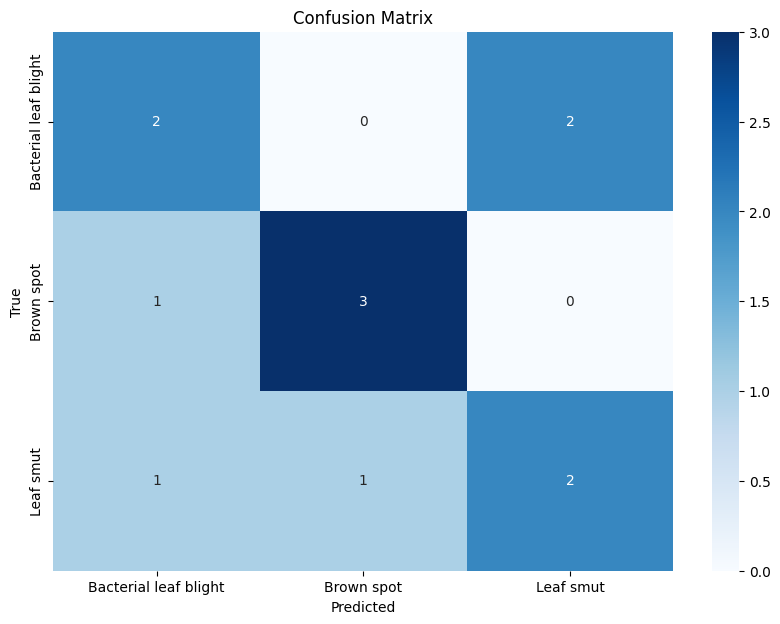

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Wizualizacja macierzy konfuzji
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


1. Pobierz zdjęcia i ich prawdziwe etykiety ze zbioru testowego
Na początek zbierz obrazy i ich prawdziwe etykiety z testowego zbioru danych.

Kod:

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Pobierz zdjęcia i ich prawdziwe etykiety
test_images, test_labels = [], []
for images, labels in test_ds:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

# Zamień na jedną tablicę
test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)


2. Dokonaj predykcji za pomocą modelu
Przewiduj klasy dla obrazów w zbiorze testowym.

Kod:

In [24]:
# Przewidź klasy dla zbioru testowego
predictions = model.predict(test_images)

# Pobierz indeksy klasy z najwyższą pewnością (największym prawdopodobieństwem)
predicted_classes = np.argmax(predictions, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Przygotuj funkcję do wizualizacji zdjęć
Stwórz funkcję, która wyświetli obrazy razem z przewidzianymi etykietami oraz prawdziwymi etykietami.

Kod:

In [25]:
# Funkcja do wyświetlania zdjęć
def display_images(images, true_labels, predicted_labels, class_names, num_images=10):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)  # 2 wiersze, 5 kolumn
        plt.imshow(images[i].astype("uint8"))  # Wyświetl obraz
        color = 'green' if true_labels[i] == predicted_labels[i] else 'red'  # Kolor etykiety
        plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}", color=color)
        plt.axis("off")  # Ukryj osie
    plt.tight_layout()
    plt.show()


Wyświetl zdjęcia
Wyświetl wybrane obrazy ze zbioru testowego z etykietami prawdziwymi i przewidzianymi.

Kod:

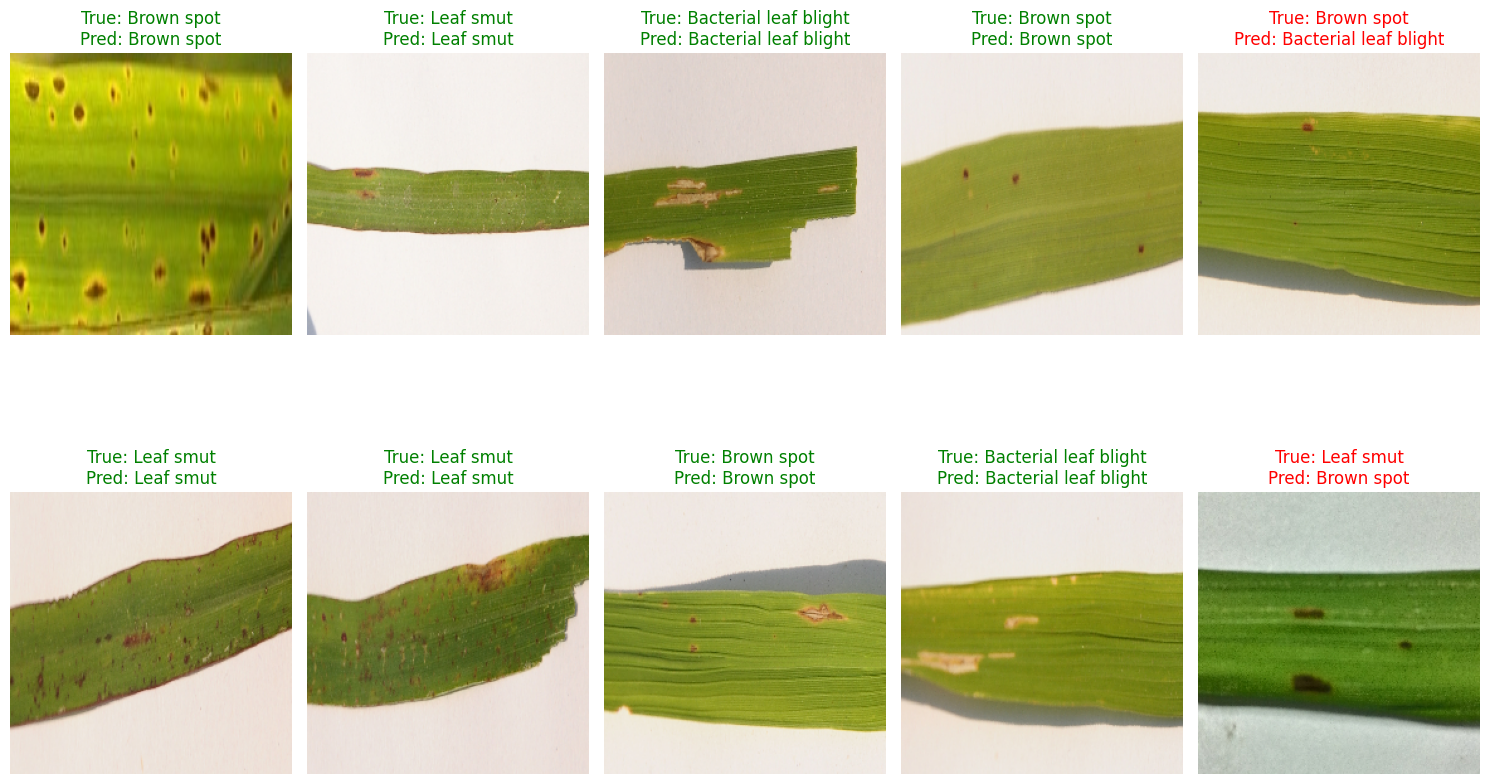

In [26]:
# Nazwy klas (pochodzą z test_ds.class_names)
class_names = test_ds.class_names

# Wyświetl zdjęcia z wynikami
display_images(test_images, test_labels, predicted_classes, class_names, num_images=10)


Parametr num_images=10: Możesz zmienić liczbę zdjęć do wyświetlenia.

Funkcja np.argmax: Pobiera indeks klasy o najwyższym prawdopodobieństwie.

